<a href="https://colab.research.google.com/github/ulisesjcaroflores/Week8-GSB530F25/blob/main/PA8_1_KNN_and_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Palmer Penguins Modeling

Import the Palmer Penguins dataset and print out the first few rows.

Suppose we want to predict `bill_depth_mm` using the other variables in the dataset.

**Dummify** all variables that require this.

In [2]:
!pip install palmerpenguins

In [74]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import *
from palmerpenguins import load_penguins
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.metrics import *
import numpy as np
from plotnine import *

penguins = load_penguins()
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,55.8,19.8,207.0,4000.0,male,2009
340,Chinstrap,Dream,43.5,18.1,202.0,3400.0,female,2009
341,Chinstrap,Dream,49.6,18.2,193.0,3775.0,male,2009
342,Chinstrap,Dream,50.8,19.0,210.0,4100.0,male,2009


In [4]:
penguins.isnull().sum()

,0
species,0
island,0
bill_length_mm,2
bill_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,11
year,0


In [5]:
penguins = penguins.dropna()

In [6]:
X = penguins.drop(columns='bill_depth_mm')
y = penguins['bill_depth_mm']

In [7]:
penguins.describe() #this is for the numeric vars

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,year
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,43.992793,17.164865,200.966967,4207.057057,2008.042042
std,5.468668,1.969235,14.015765,805.215802,0.812944
min,32.100000,13.100000,172.000000,2700.000000,2007.000000
25%,39.500000,15.600000,190.000000,3550.000000,2007.000000
50%,44.500000,17.300000,197.000000,4050.000000,2008.000000
75%,48.600000,18.700000,213.000000,4775.000000,2009.000000
max,59.600000,21.500000,231.000000,6300.000000,2009.000000


Let's use the other variables to predict `bill_depth_mm`. Prepare your data and fit the following models on the entire dataset:

* Your best multiple linear regression model from before
* Two kNN models (for different values of K)
* A decision tree model

Create a plot like the right plot of Fig 1. in our `Model Validation` chapter with the training and test error plotted for each of your four models.

Which of your models was best?

In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=321)

#don't use because we need to use grid search to find some models
#just fit on X,y

In [8]:
ct = ColumnTransformer([
    ("scalar", StandardScaler(), make_column_selector(dtype_include=np.number)),
    ("ohe", OneHotEncoder(drop="first", handle_unknown='ignore', sparse_output = False), make_column_selector(dtype_include=object))],
    remainder = 'passthrough'
).set_output(transform="pandas")

scoring = {
    "MSE":  "neg_mean_squared_error",
    "RMSE": "neg_root_mean_squared_error",
    "MAE":  "neg_mean_absolute_error",
    "R2":   "r2",
}

In [12]:
lr_pipeline = Pipeline([
    ("ct", ct),
    ("lr", LinearRegression())
])
lr_pipeline.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalar', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869ba2b3140>),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869b8c13380>)])),
                ('lr', LinearRegression())])

In [14]:
cv_lr = cross_validate(lr_pipeline, X, y, scoring=scoring, cv=10, return_train_score=False)

result_lr = pd.Series({
    "MSE":  -cv_lr["test_MSE"].mean(),
    "RMSE": -cv_lr["test_RMSE"].mean(),
    "MAE":  -cv_lr["test_MAE"].mean(),
    "R2":   cv_lr["test_R2"].mean(),
},name='Linear Regression')

result_lr

,Linear Regression
MSE,0.720165
RMSE,0.826275
MAE,0.663200
R2,0.491843


In [11]:
#these are the same!

cv_lr = cross_val_score(lr_pipeline, X, y, scoring='neg_mean_squared_error', cv=10)
estimated_mselr = -cv_lr.mean()
print(f"Estimated MSE for Linear Regression: {estimated_mselr:.4f}")

Estimated MSE for Linear Regression: 0.7202


In [15]:
pipeline_knn = Pipeline([
    ("ct", ct),
    ("knn", KNeighborsRegressor())
])

In [16]:
paraGrid = {
    'knn__n_neighbors': range(1, 10+1),
    'knn__metric': ['manhattan', 'euclidean'] #Changed 'metric' to 'knn__metric' and standardized metric names
}
search = GridSearchCV(pipeline_knn, paraGrid, cv=10, scoring=scoring, refit="MSE") #trains for all metrics but selects the one specified.
KNN_fit = search.fit(X, y)
pd.DataFrame(KNN_fit.cv_results_).sort_values(by='rank_test_MSE')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_knn__metric,param_knn__n_neighbors,params,split0_test_MSE,split1_test_MSE,split2_test_MSE,...,split3_test_R2,split4_test_R2,split5_test_R2,split6_test_R2,split7_test_R2,split8_test_R2,split9_test_R2,mean_test_R2,std_test_R2,rank_test_R2
8,0.011579,0.000549,0.010597,0.000544,manhattan,9,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-1.533453,-0.668925,-0.916264,...,0.420482,0.823856,0.613555,0.574743,0.745943,0.445418,0.602711,0.501824,0.220779,1
7,0.011678,0.000699,0.010379,0.000253,manhattan,8,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-1.536273,-0.688920,-0.966521,...,0.467798,0.817566,0.600382,0.586022,0.744429,0.450279,0.614387,0.501612,0.223442,2
9,0.012727,0.002227,0.011506,0.001785,manhattan,10,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-1.548268,-0.662568,-0.899938,...,0.430140,0.807322,0.581300,0.571175,0.748534,0.453739,0.587413,0.497922,0.216837,3
16,0.011707,0.000747,0.010701,0.001045,euclidean,7,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-1.427113,-0.684850,-0.896711,...,0.442677,0.799706,0.586549,0.578492,0.768884,0.376515,0.494806,0.491086,0.202317,4
6,0.011420,0.000264,0.010383,0.000130,manhattan,7,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-1.527653,-0.752425,-0.997209,...,0.480893,0.816810,0.606422,0.580755,0.739891,0.374639,0.613468,0.488174,0.227967,5
17,0.021169,0.026405,0.011596,0.002242,euclidean,8,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-1.455437,-0.697096,-0.899053,...,0.454533,0.803363,0.552684,0.559022,0.755838,0.377726,0.483881,0.482099,0.202552,6
5,0.011582,0.000674,0.010442,0.000396,manhattan,6,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-1.657034,-0.785082,-1.010605,...,0.487682,0.825029,0.585143,0.615745,0.747215,0.358507,0.636126,0.480600,0.252152,7
4,0.012537,0.002046,0.011590,0.001787,manhattan,5,"{'knn__metric': 'manhattan', 'knn__n_neighbors...",-1.734824,-0.790506,-1.007847,...,0.523473,0.827185,0.610458,0.577791,0.748224,0.379079,0.640382,0.480520,0.262686,8
18,0.012861,0.002087,0.011100,0.001466,euclidean,9,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-1.473057,-0.667495,-0.899325,...,0.476046,0.800463,0.554124,0.573094,0.741062,0.366065,0.406361,0.476194,0.204983,10
15,0.011683,0.000716,0.010502,0.000285,euclidean,6,"{'knn__metric': 'euclidean', 'knn__n_neighbors...",-1.545163,-0.733554,-0.969804,...,0.424164,0.802757,0.591005,0.558246,0.740262,0.426541,0.529857,0.476615,0.219462,9


In [17]:
KNN_fit.best_estimator_.named_steps['knn']

KNeighborsRegressor(metric='manhattan', n_neighbors=9)

In [18]:
#same as the best estimator
KNN_fit.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 9}

In [19]:
knn_pipe9 = Pipeline([
    ("ct", ct),
    ("knn", KNeighborsRegressor(n_neighbors=9, metric='manhattan'))
])
knn_pipe9.fit(X, y) #find the cv and compare the mse.

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalar', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869ba2b3140>),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869b8c13380>)])),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=9))])

In [20]:
cv_knn9 = cross_validate(knn_pipe9, X, y,scoring=scoring,cv=10,return_train_score=False)

result_knn9 = pd.Series({
    "MSE":  -cv_knn9["test_MSE"].mean(),
    "RMSE": -cv_knn9["test_RMSE"].mean(),
    "MAE":  -cv_knn9["test_MAE"].mean(),
    "R2":   cv_knn9["test_R2"].mean(),
},name='KNN Regression (n=9; manhattan)')

result_knn9

,KNN Regression (n=9; manhattan)
MSE,0.684752
RMSE,0.806683
MAE,0.646451
R2,0.501824


In [21]:
cv_knn1 = cross_val_score(knn_pipe9, X, y, scoring='neg_mean_squared_error', cv=10)
estimated_mse2 = -cv_knn1.mean()
print(f"Estimated MSE for KNN Regression with 9 nearest neighbors using manhattan as the metric: {estimated_mse2:.4f}")

Estimated MSE for KNN Regression with 9 nearest neighbors using manhattan as the metric: 0.6848


In [22]:
knn_pipe7 = Pipeline([
    ("ct", ct),
    ("knn", KNeighborsRegressor(n_neighbors=7, metric='euclidean'))
])
knn_pipe7.fit(X, y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalar', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869ba2b3140>),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869b8c13380>)])),
                ('knn',
                 KNeighborsRegressor(metric='euclidean', n_neighbors=7))])

In [23]:
cv_knn7 = cross_validate(knn_pipe7, X, y, scoring=scoring, cv=10, return_train_score=False)

result_knn7 = pd.Series({
    "MSE":  -cv_knn7["test_MSE"].mean(),
    "RMSE": -cv_knn7["test_RMSE"].mean(),
    "MAE":  -cv_knn7["test_MAE"].mean(),
    "R2":   cv_knn7["test_R2"].mean(),
},name='KNN Regression (n=7; euclidean)')

result_knn7

,KNN Regression (n=7; euclidean)
MSE,0.699658
RMSE,0.818656
MAE,0.656999
R2,0.491086


In [24]:
cv_knn2 = cross_val_score(knn_pipe7, X, y, scoring='neg_mean_squared_error', cv=10)
estimated_mse3 = -cv_knn2.mean()
print(f"Estimated MSE for KNN Regression with 7 nearest neighbors using euclidean as the metric: {estimated_mse3:.4f}")

Estimated MSE for KNN Regression with 7 nearest neighbors using euclidean as the metric: 0.6997


In [25]:
pipeline_dt = Pipeline([
    ("ct", ct),
    ("dt", DecisionTreeRegressor())
])

In [35]:
params = {
    "dt__max_depth": [None, 3, 5, 7, 10, 15, 20],
    "dt__ccp_alpha": np.linspace(0, 0.1, 10)
}

search_dt = GridSearchCV(pipeline_dt, param_grid=params, cv=10, scoring=scoring, refit="MSE")
dt_fit = search_dt.fit(X, y)
pd.DataFrame(dt_fit.cv_results_).sort_values(by='rank_test_MSE')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dt__ccp_alpha,param_dt__max_depth,params,split0_test_MSE,split1_test_MSE,split2_test_MSE,...,split3_test_R2,split4_test_R2,split5_test_R2,split6_test_R2,split7_test_R2,split8_test_R2,split9_test_R2,mean_test_R2,std_test_R2,rank_test_R2
56,0.013442,0.000608,0.009492,0.000112,0.088889,None,"{'dt__ccp_alpha': 0.08888888888888889, 'dt__ma...",-1.471074,-0.642718,-0.714898,...,0.360065,0.684776,0.578457,0.581942,0.652285,0.453554,0.589710,0.491002,0.173734,1
63,0.013622,0.001010,0.009838,0.000496,0.100000,None,"{'dt__ccp_alpha': 0.1, 'dt__max_depth': None}",-1.471074,-0.642718,-0.714898,...,0.360065,0.684776,0.578457,0.581942,0.652285,0.453554,0.589710,0.491002,0.173734,1
31,0.013590,0.002430,0.010525,0.001811,0.044444,7,"{'dt__ccp_alpha': 0.044444444444444446, 'dt__m...",-1.471074,-0.642718,-0.714898,...,0.360065,0.684776,0.578457,0.581942,0.652285,0.453554,0.589710,0.491002,0.173734,3
50,0.018057,0.002616,0.016040,0.003710,0.077778,3,"{'dt__ccp_alpha': 0.07777777777777778, 'dt__ma...",-1.471074,-0.642718,-0.714898,...,0.360065,0.684776,0.578457,0.581942,0.652285,0.453554,0.589710,0.491002,0.173734,6
45,0.017724,0.000943,0.013808,0.000677,0.066667,7,"{'dt__ccp_alpha': 0.06666666666666667, 'dt__ma...",-1.471074,-0.642718,-0.714898,...,0.360065,0.684776,0.578457,0.581942,0.652285,0.453554,0.589710,0.491002,0.173734,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0.081119,0.037071,0.059604,0.030454,0.000000,7,"{'dt__ccp_alpha': 0.0, 'dt__max_depth': 7}",-1.891189,-1.148090,-1.497561,...,0.303694,0.697093,0.440781,0.453742,0.548400,0.157864,0.345858,0.269206,0.281743,66
4,0.019194,0.004122,0.014908,0.003389,0.000000,10,"{'dt__ccp_alpha': 0.0, 'dt__max_depth': 10}",-1.993336,-1.428514,-1.941585,...,0.122952,0.690966,0.478059,0.364798,0.503801,0.088235,0.272001,0.164031,0.357523,67
5,0.013074,0.000679,0.010090,0.000711,0.000000,15,"{'dt__ccp_alpha': 0.0, 'dt__max_depth': 15}",-2.216765,-1.339118,-1.763824,...,0.226390,0.675400,0.388772,0.378358,0.429820,-0.033059,0.214892,0.146315,0.338660,68
0,0.035050,0.016489,0.024253,0.005593,0.000000,None,"{'dt__ccp_alpha': 0.0, 'dt__max_depth': None}",-2.052353,-1.604412,-1.807647,...,0.110553,0.676073,0.454322,0.462297,0.435018,0.059645,0.189651,0.144147,0.350749,69


In [39]:
dt_fit.best_estimator_.named_steps["dt"]

DecisionTreeRegressor(ccp_alpha=np.float64(0.08888888888888889))

In [40]:
pipe_dt3 = Pipeline([
    ("ct", ct),
    ("dt", DecisionTreeRegressor(max_depth=3, ccp_alpha=0.09))
])

pipe_dt3.fit(X,y)

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scalar', StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869ba2b3140>),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7869b8c13380>)])),
                ('dt', DecisionTreeRegressor(ccp_alpha=0.09, max_depth=3))])

In [42]:
cv_dt3 = cross_validate(pipe_dt3, X, y, scoring=scoring, cv=10, return_train_score=False)

result_dt3 = pd.Series({
    "MSE":  -cv_dt3["test_MSE"].mean(),
    "RMSE": -cv_dt3["test_RMSE"].mean(),
    "MAE":  -cv_dt3["test_MAE"].mean(),
    "R2":   cv_dt3["test_R2"].mean(),
},name='Decision Tree (depth=3, cpp_alpha=0.9)')

result_dt3

,"Decision Tree (depth=3, cpp_alpha=0.9)"
MSE,0.720453
RMSE,0.832737
MAE,0.673449
R2,0.491002


In [47]:
table = pd.concat([result_lr, result_knn9, result_knn7, result_dt3], axis=1).T
table.sort_values(by='MSE', ascending=False).style.format({"MSE": "{:.4f}", "RMSE": "{:.4f}", "MAE": "{:.4f}", "R2": "{:.4f}"})

,MSE,RMSE,MAE,R2
"Decision Tree (depth=3, cpp_alpha=0.9)",0.7205,0.8327,0.6734,0.4910
Linear Regression,0.7202,0.8263,0.6632,0.4918
KNN Regression (n=7; euclidean),0.6997,0.8187,0.6570,0.4911
KNN Regression (n=9; manhattan),0.6848,0.8067,0.6465,0.5018


In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=321)

In [78]:
models = {
    "Linear Regression": lr_pipeline,
    "KNN (n=9, manhattan)": knn_pipe9,
    "KNN (n=7, euclidean)": knn_pipe7,
    "DT (depth=3, cpp_alpha=0.9)": pipe_dt3
}

results =[]

In [79]:
for name, model in models.items():

    model.fit(X_train, y_train)

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    results.append({"Model": name, "Train MSE": train_mse, "Test MSE": test_mse})

In [80]:
table2 = pd.DataFrame(results)
table2.sort_values(by='Test MSE',ascending=False).style.format({"Train MSE":"{:.4f}", "Test MSE": "{:.4f}"})

,Model,Train MSE,Test MSE
0,Linear Regression,0.5795,0.7134
2,"KNN (n=7, euclidean)",0.5067,0.7130
3,"DT (depth=3, cpp_alpha=0.9)",0.6913,0.6755
1,"KNN (n=9, manhattan)",0.5158,0.6699


In [81]:
plot_df = table2.melt(id_vars='Model', var_name='Metric', value_name='MSE')
plot_df

,Model,Metric,MSE
0,Linear Regression,Train MSE,0.579540
1,"KNN (n=9, manhattan)",Train MSE,0.515811
2,"KNN (n=7, euclidean)",Train MSE,0.506659
3,"DT (depth=3, cpp_alpha=0.9)",Train MSE,0.691259
4,Linear Regression,Test MSE,0.713372
5,"KNN (n=9, manhattan)",Test MSE,0.669936
6,"KNN (n=7, euclidean)",Test MSE,0.712958
7,"DT (depth=3, cpp_alpha=0.9)",Test MSE,0.675530


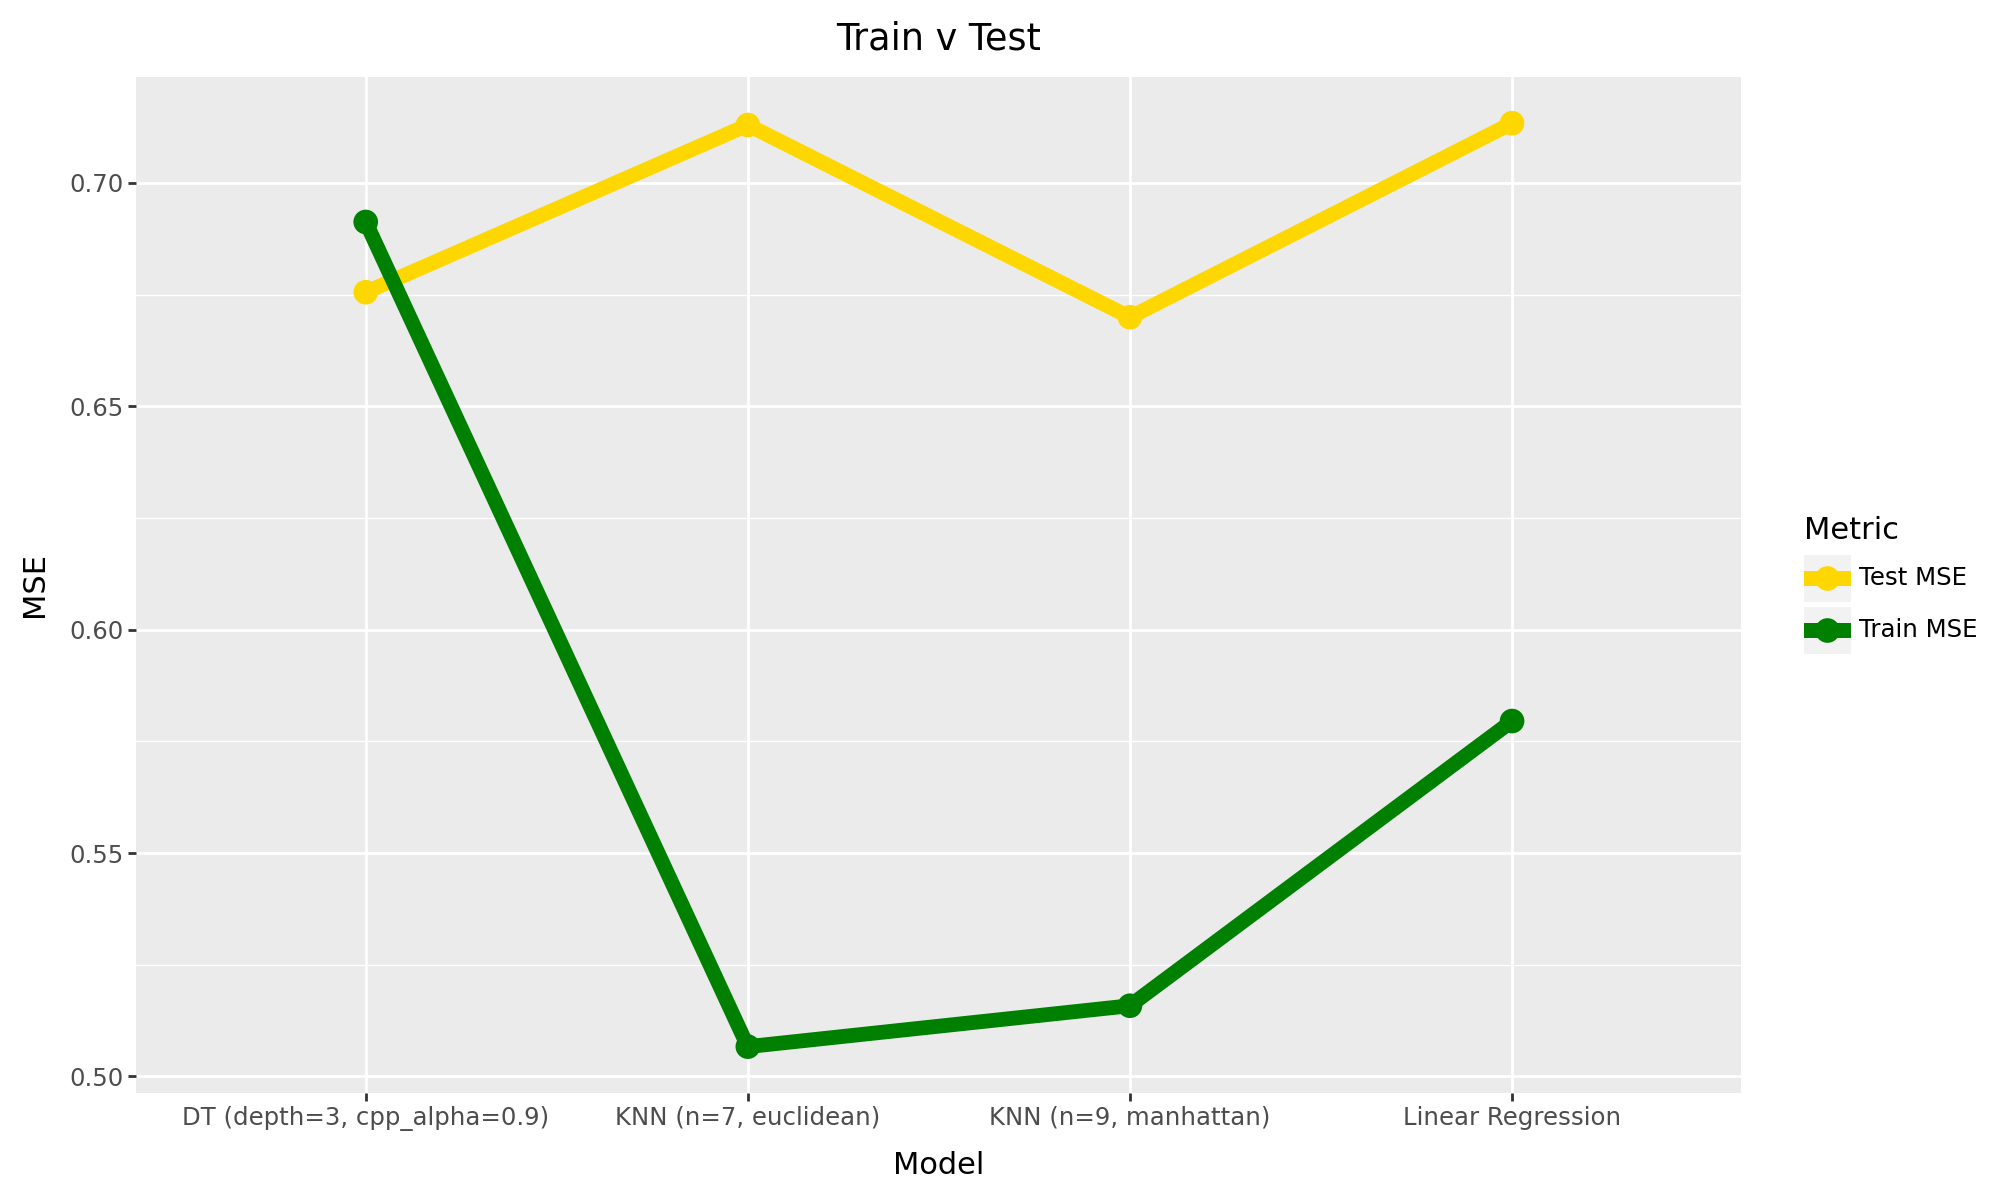

In [82]:
(ggplot(plot_df, aes(x='Model', y='MSE', color='Metric', group="Metric"))
    + geom_line(size=3)
    + geom_point(size=4)
    + scale_color_manual(values={
        "Train MSE": "green",
        "Test MSE": "gold"
    })
    + labs(
        title="Train v Test",
        x='Model',
        y='MSE')
    + theme(figure_size=(10,6)))

# Task
Modify the `paraGrid` dictionary to correctly target the `n_neighbors` parameter of the `KNeighborsRegressor` within the pipeline. Change `'n_neighbors'` to `'knn__n_neighbors'`.

## Adjust `paraGrid` for Pipeline

### Subtask:
Modify the `paraGrid` dictionary to correctly target the `n_neighbors` parameter of the `KNeighborsRegressor` within the pipeline. Change `'n_neighbors'` to `'knn__n_neighbors'`.


## Summary:

### Data Analysis Key Findings
*   The `paraGrid` dictionary was successfully modified to target the `n_neighbors` parameter of the `KNeighborsRegressor` within a pipeline by changing the key from `'n_neighbors'` to `'knn__n_neighbors'`.

### Insights or Next Steps
*   When performing hyperparameter tuning for models within a `Pipeline`, it is crucial to prefix the parameter names with the corresponding step's name followed by a double underscore (e.g., `step_name__parameter_name`) to ensure correct targeting.
